In [1]:
import json
import numpy as np
import os
# add the parent directory to the Python path
import sys
sys.path.append(os.path.abspath("../.."))   # one level up from notebook/
import matplotlib.pyplot as plt
import torch
from data.utils.dataloaders import get_imagenet_dataloader


/BS/data_mani_compress/work/miniforge3/envs/dgm_geometry/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# save json file
with open('/BS/data_mani_compress/work/thesis/thesis/data/datasets/density_imagenet/original_val/unconditional/combined.json', 'r') as f:
    density = json.load(f)

density_fixed = [sum(v[0][::]) for v in density]


In [4]:
def denormalize(img_tensor):
    mean = torch.tensor([0.485, 0.456, 0.406], device=img_tensor.device).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225], device=img_tensor.device).view(3, 1, 1)
    return img_tensor * std + mean

In [5]:
imagenet_val = get_imagenet_dataloader(split="val_categorized", batch_size=4)

In [6]:
# find the indices of lowest and highest LID values
density_np = np.asarray(density_fixed, dtype=np.float64)
# argsort returns indices that would sort the array ascending
order = np.argsort(density_np)
lowest_indices = order[:50].tolist()
highest_indices = order[-50:][::-1].tolist()  # top 20 in descending order
lowest_values = density_np[lowest_indices].tolist()
highest_values = density_np[highest_indices].tolist()

# also get the mid LID values for comparison
mid_start = len(density_np) // 2 - 25
mid_indices = order[mid_start:mid_start + 50].tolist()
mid_values = density_np[mid_indices].tolist()

In [7]:
print('Lowest 10 indices/values:')
for idx, val in zip(lowest_indices, lowest_values):
    print(idx, val)
print('\nHighest 10 indices/values:')
for idx, val in zip(highest_indices, highest_values):
    print(idx, val)

Lowest 10 indices/values:
36332 16676.88282775879
21861 16696.501861572266
1663 16762.07869720459
201 16773.121421813965
30812 16861.05516052246
2941 16979.45928955078
47336 17027.024688720703
5916 17079.71533203125
18751 17100.679122924805
17940 17219.032806396484
318 17305.819328308105
14926 17471.603912353516
22832 17483.010650634766
18274 17505.42886352539
1270 17516.165817260742
29965 17551.73356628418
49681 17559.538330078125
39411 17595.19175720215
2888 17605.71743774414
49404 17617.41064453125
4112 17618.128875732422
1657 17632.784378051758
16803 17657.270126342773
646 17659.21954345703
47384 17673.609832763672
3215 17702.677520751953
46417 17718.31916809082
18757 17725.157913208008
2780 17730.183135986328
4307 17730.53338623047
28648 17731.09457397461
16419 17732.745346069336
5915 17752.477081298828
4561 17754.44920349121
16555 17754.60710144043
2616 17756.294235229492
47236 17760.487213134766
6563 17768.101028442383
47353 17773.723373413086
14639 17774.441680908203
8207 17776

Saved density_grid.pdf and density_grid.png


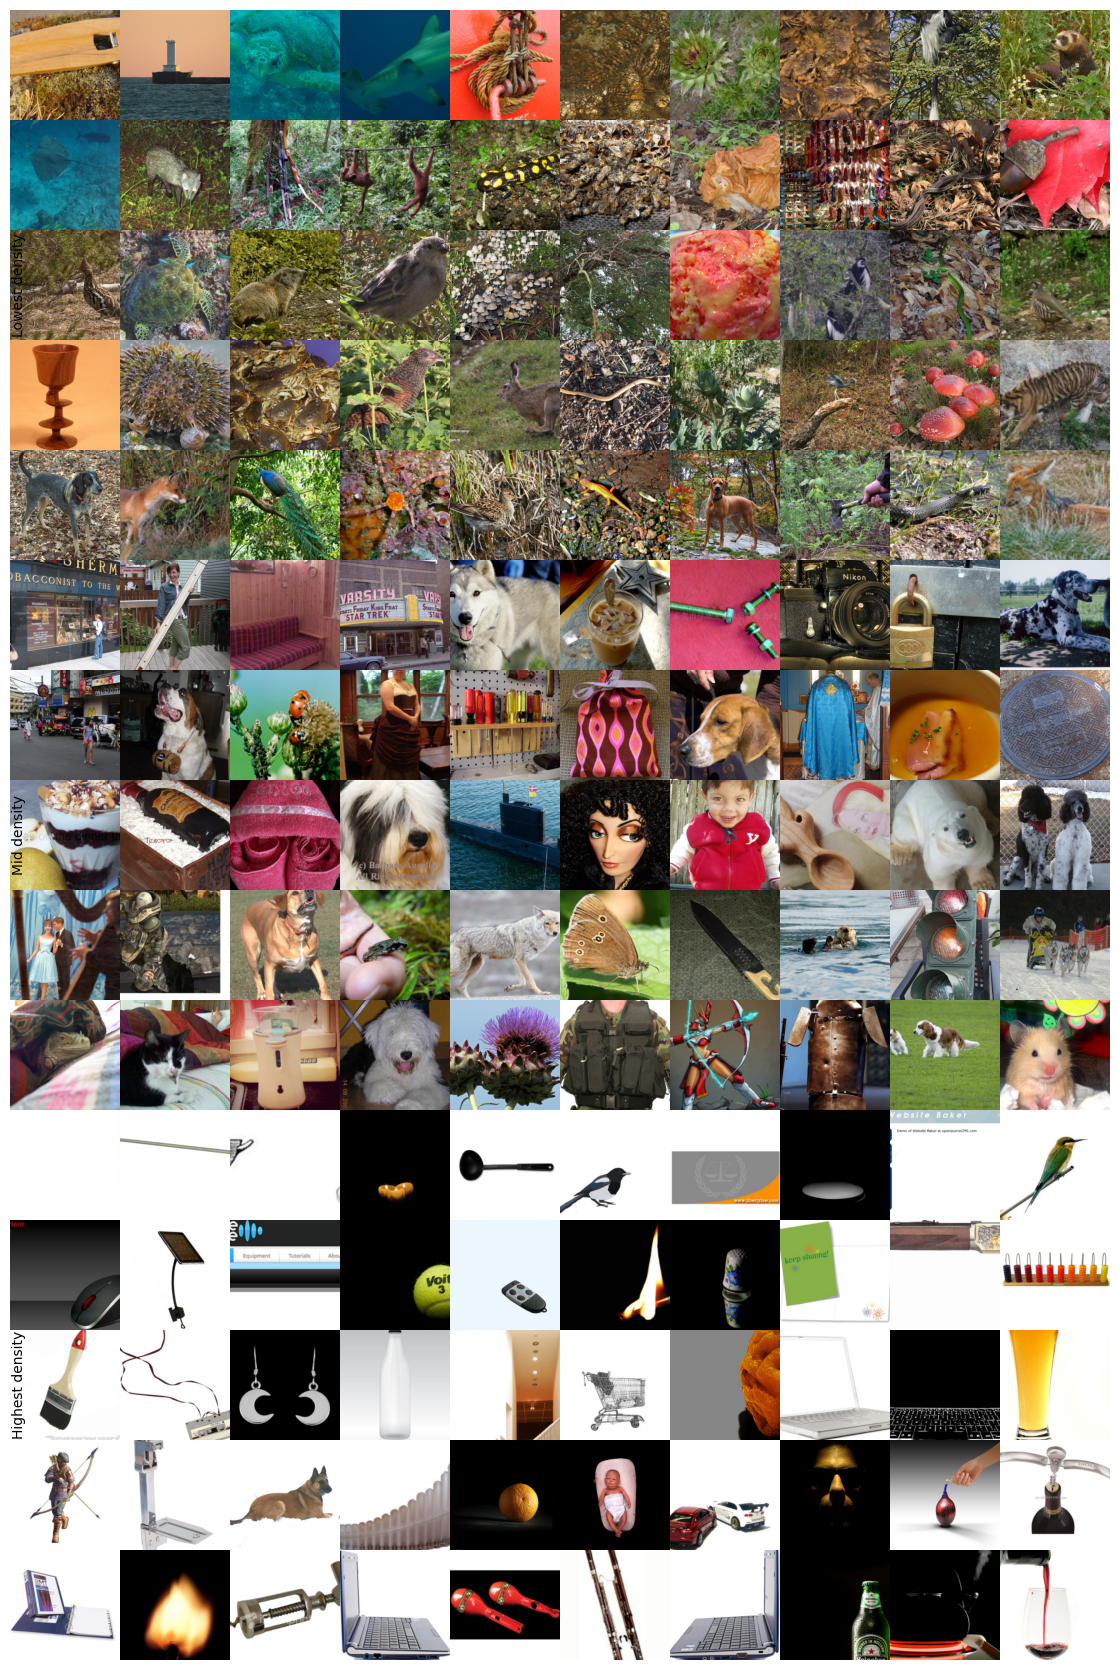

In [8]:
# Compact visualization: remove whitespace and save as PDF
import matplotlib.pyplot as plt
from pathlib import Path

# Parameters
n = 50              # images per group
rows, cols = 5, 10  # grid per group
assert rows * cols >= n, "rows*cols must cover n"

# Prepare groups
groups = [
    ("Lowest density", lowest_indices[:n]),
    ("Mid density",    mid_indices[:n]),
    ("Highest density", highest_indices[:n]),
]

H = rows * len(groups)
W = cols
fig_h = 1.1 * H   # figure size scales roughly with tile count
fig_w = 1.1 * W
fig, axs = plt.subplots(H, W, figsize=(fig_w, fig_h))

# Ensure axs is 2D
if H == 1:
    axs = axs[None, :]

# Draw tiles
for gi, (gname, indices) in enumerate(groups):
    for i, idx in enumerate(indices):
        r_local, c = divmod(i, cols)
        r = gi * rows + r_local
        ax = axs[r, c]
        img = imagenet_val.dataset[idx][0]
        img = denormalize(img).clamp(0, 1).permute(1, 2, 0).cpu()
        ax.imshow(img)
        ax.set_axis_off()

# Remove all spacing and margins
plt.subplots_adjust(left=0, right=1, top=1, bottom=0, wspace=0, hspace=0)

# Minimal group labels on the left margin without changing layout
for gi, (gname, _) in enumerate(groups):
    y = 1 - (gi + 0.5) / len(groups)
    fig.text(0.002, y, gname, va='center', ha='left', fontsize=10, color='black', rotation=90)

# Save outputs with no padding
out_pdf = Path("density_grid.pdf")
out_png = Path("density_grid.png")
fig.savefig(out_pdf, bbox_inches='tight', pad_inches=0, dpi=300)
fig.savefig(out_png, bbox_inches='tight', pad_inches=0, dpi=300)
print(f"Saved {out_pdf} and {out_png}")

plt.show()
